In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Read user login information

In [2]:
df_login = pd.read_csv('takehome_user_engagement.csv')

In [3]:
df_login.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df_login.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [5]:
df_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period

In [6]:
from datetime import date

In [7]:
# Convert the datetime to date format
df_login.time_stamp = pd.to_datetime(df_login.time_stamp).apply(lambda x: x.date())

In [8]:
# Create new dataframe of count the login times per user per day
df_login_new = df_login.groupby(['user_id','time_stamp']).sum()

# Define methods of telling whether user is adopted user

def adopted_users(n):
    # select subset dataframe at specific userid
    df_login_new_sub = df_login_new.loc[n]
    
    # select login_time
    login_time = df_login_new_sub.visited.values
    
    # when more than 2 times login, the user will be evaluated as adopted user or not
    if len(login_time)>2:
        for i in range(len(login_time)-2):
            # tell if the next two login time is within 7 days period
            if (df_login_new_sub.index[i+2]-df_login_new_sub.index[i]).days<=7:
                return True
        # return false if the next two login time is not within 7 days period
        return False
    # return false if equal or less than 2 times login
    else:
        return False

In [9]:
# Obtain adopted user list
adopted_users_list = []

for i in df_login.user_id.unique():
    # Generate dictionary mapping whether specific id is adopted user or not
    if adopted_users(i):
        adopted_users_list.append(i)

***

## 2. Data cleaning

In [10]:
# read user information
df_user = pd.read_csv('takehome_users.csv',encoding='ISO-8859-1')

In [11]:
# Creat column 'adopted_users' and label each user with adopted (0 or 1)
df_user['adopted_user'] = df_user.object_id.apply(lambda x: 1 if x in adopted_users_list else 0)

In [12]:
# Only 13.8% users are adopted users
len(adopted_users_list)/len(set(df_user.object_id))

0.138

In [13]:
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [14]:
# Create column 'invited' to record inviting user is adopted user, non adopted user or no invitating user
# 2 if invited_by_user_id is adopted user, 1 if invited_by_user_id is NOT adopted user, and 0 if no invited_by_user_id

df_user['invited'] = df_user.invited_by_user_id.apply(lambda x: 2 if x in adopted_users_list else 1 if str(x)=='nan' else 0)

In [15]:
# Creat new column 'year_before_current' to record how many years creation time is before 2014. 
# 0 represents creation year is 2014, 1 represents creation year is 2013, and 2 represent 2012

df_user['year_before_current'] = 0

df_user.year_before_current = df_user.creation_time.apply(lambda x: 2 if x.startswith('2012') else 1 if x.startswith('2013') else 0)

In [16]:
# Creat labels for creation_source
creation_source_map = dict(zip(df_user.creation_source.unique(), range(5)))

# range(5) labels ['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS', 'SIGNUP_GOOGLE_AUTH']
df_user.creation_source = df_user.creation_source.map(creation_source_map)

In [17]:
# Drop unrelated columns

df_user.drop(['object_id', 'creation_time', 
              'name', 'email', 
              'last_session_creation_time', 'invited_by_user_id'], axis = 1, inplace = True)

In [18]:
df_user.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,invited,year_before_current
0,0,1,0,11,0,0,0
1,1,0,0,1,1,0,1
2,1,0,0,94,0,2,1
3,0,0,0,1,0,2,1
4,0,0,0,193,0,2,1


## 3. Data Analysis

In [19]:
def feature_influence(column):
    adopted_rate = df_user.groupby(column)['adopted_user'].mean()
    return adopted_rate

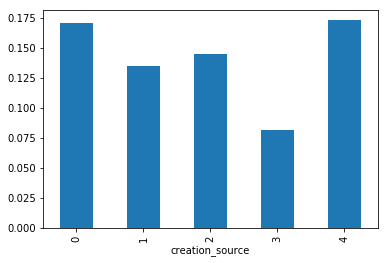

In [55]:
creation_source = feature_influence('creation_source')

creation_source.plot(kind='bar')

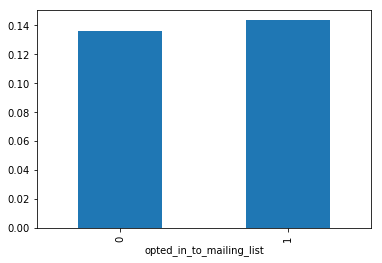

In [26]:
opted_in_to_mailing_list= feature_influence('opted_in_to_mailing_list')

opted_in_to_mailing_list.plot(kind='bar')

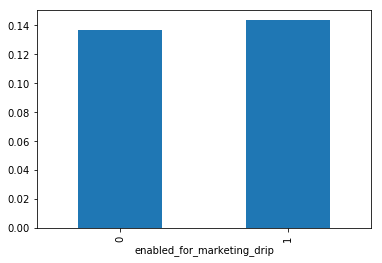

In [25]:
enabled_for_marketing_drip= feature_influence('enabled_for_marketing_drip')

enabled_for_marketing_drip.plot(kind='bar')

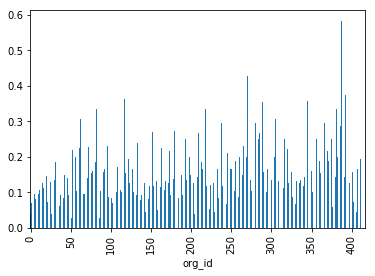

In [37]:
org_id= feature_influence('org_id')

org_id.plot(kind='bar')
_ = plt.xticks(range(0, 417, 50), range(0, 417, 50))

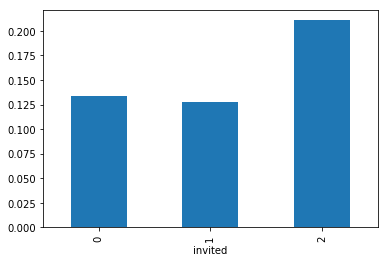

In [38]:
invited= feature_influence('invited')

invited.plot(kind='bar')

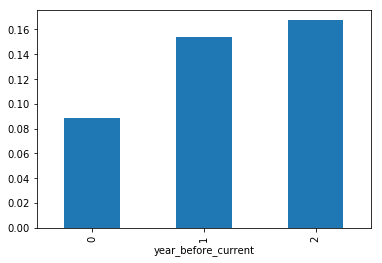

In [39]:
year_before_current= feature_influence('year_before_current')

year_before_current.plot(kind='bar')

## 4. Data modeling and prediction

In [40]:
# Generate xdata and ydata
xdata = df_user.drop('adopted_user', axis=1).values
ydata = df_user.adopted_user

In [41]:
# Split data to training and testing data
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size = 0.3, random_state = 1)

In [42]:
# Use random forest model to fit and predict the adoptive users
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)
rf_predict = rf.predict(xtest)
rf_predict_prob = rf.predict_proba(xtest)[:,1]

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

#### Model performance with threshold = 0.5

In [44]:
accuracy_score(ytest, rf_predict)

0.80333333333333334

In [46]:
roc_auc_score(ytest, rf_predict)

0.51383463541666663

In [47]:
f1_score(ytest, rf_predict)

0.13447432762836187

In [45]:
confusion_matrix(ytest, rf_predict)

array([[2837,  235],
       [ 473,   55]])

#### Model performance with threshold = 0.4

In [58]:
accuracy_score(ytest, (rf_predict_prob>0.4).astype(int))

0.78083333333333338

In [48]:
roc_auc_score(ytest, (rf_predict_prob>0.4).astype(int))

0.51868785511363635

In [59]:
f1_score(ytest, (rf_predict_prob>0.4).astype(int))

0.16507936507936508

In [60]:
confusion_matrix(ytest, (rf_predict_prob>0.4).astype(int))

array([[2733,  339],
       [ 450,   78]])

Decrease the threshold will increase the true positive rate (rate of correctly prediction given true results), with sacrifice of true negative rate

#### Select important features

In [50]:
df_user.columns

Index(['creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'adopted_user', 'invited',
       'year_before_current'],
      dtype='object')

In [51]:
rf.feature_importances_

array([ 0.03938321,  0.01608643,  0.01411006,  0.87918958,  0.01707541,
        0.03415532])

It is indicated that org_id is the most important feature determining adoptive users. Using current features and data, we achieved low roc_auc_score and f1_score. It is probably due to 1) The original data is highly imbalanced (only 13.8% users are adoptive users), we will need to collect more information of adoptive users; 2) We need more related features that will help to predict the adoptive users.